<a href="https://colab.research.google.com/github/EikEUFS/AprendizadoDeMaquina/blob/main/AM_Tarefa04A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Resultados

Foi treinado com 200 epocas, porém percebi que dava para melhorar mais, ai botei 500, vi que dava para melhorar mais, coloquei 1000 e percebi que era demais. Então a curva parava de se achatar com uns 750-800 épocas. E teve uma perplexy de 4.6 em um tempo de 12 minutos de treinamento.

In [ ]:
!pip install d2l==0.16.4
!pip install -U mxnet-cu110==1.8.0 

In [2]:
%matplotlib inline
import re
import random

from mxnet import autograd, context, gluon, image, init, np, npx
from mxnet.gluon import nn, rnn
from mxnet.gluon import utils as gutils

from d2l import mxnet as d2l

npx.set_np()

data_dir = '.'
base_url = 'https://raw.githubusercontent.com/EikEUFS/AprendizadoDeMaquina/main/_aux.py'
fname = gutils.download(base_url, path=data_dir)

import _aux

In [3]:
def read_book(url):
    with open(gutils.download(url), 'r', encoding='latin-1') as f:
        lines = f.readlines()
    return [re.sub('[^A-ZÀ-Úa-zà-ú]+', ' ', line).strip().lower() for line in lines]

def read_books():
  books = [
           'https://aplauso.imprensaoficial.com.br/edicoes/12.0.813.795/12.0.813.795.txt',
           'https://aplauso.imprensaoficial.com.br/edicoes/12.0.813.105/12.0.813.105.txt',
           'https://aplauso.imprensaoficial.com.br/edicoes/12.0.813.627/12.0.813.627.txt',
           'https://aplauso.imprensaoficial.com.br/edicoes/12.0.813.977/12.0.813.977.txt',
           'https://aplauso.imprensaoficial.com.br/edicoes/12.0.813.214/12.0.813.214.txt',
          ]

  lines = []

  for url in books:
    lines = lines + read_book(url)
  return lines  

def load_corpus_books(max_tokens=-1):
    lines = read_books()
    tokens = _aux.tokenize(lines, 'word')
    vocab = _aux.Vocab(tokens)
    
    corpus = [vocab[token] for line in tokens for token in line]

    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

class SeqDataLoader:
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = _aux.seq_data_iter_random
        else:
            self.data_iter_fn = _aux.seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_books(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

def data_loader_books(batch_size, num_steps, use_random_iter=False, max_tokens=20000):    
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [4]:
batch_size, num_steps = 32, 35
train_iter, vocab = data_loader_books(batch_size, num_steps)

vocab_size, num_hiddens, device = len(vocab), 256, _aux.try_gpu()
num_epochs, lr = 800, 1

lstm_layer = rnn.LSTM(num_hiddens)
model = _aux.RNNModel(lstm_layer, vocab_size)

perplexity 4.6, 20551.7 tokens/sec on gpu(0)
time<unk>travellernãoseumportuguêselequeocorpoinicialoteatroeraumavezcomoopúblicoapastadepaulopaulononossoohoteloquartoesedentroparaomaisdogerenteomeiodaculturalamentarembaixoempalcooqueeraopalcoda
travellerocharmeéoqueoespetáculoemculturaemtrabalhosobrasileraocentrodanossacidadeeraemqueoquenãonomeiodespaulofoiacarroçadeourooteatroeraquasequeiasãoanoseraquenãoéumtrabalhoque
CPU times: user 13min 20s, sys: 9.88 s, total: 13min 30s
Wall time: 12min 26s


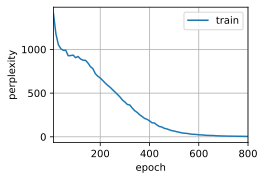

In [5]:
%%time
_aux.train_ch8(model, train_iter, vocab, lr, num_epochs, device)

In [6]:
def predict_ch8(prefix, num_preds, net, vocab, device):
    state = net.begin_state(batch_size=1, ctx=device)
    prefix = prefix.split()
    outputs = [vocab[prefix[0]]]
    get_input = lambda: _aux.reshape(_aux.tensor([outputs[-1]], ctx=device), (1, 1))
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(axis=1).reshape(1)))
    return ' '.join([vocab.idx_to_token[i] for i in outputs])

In [7]:
predict_ch8('filme de', 5, model, vocab, device)

'filme de ouro e fernando muralha de'